<a href="https://colab.research.google.com/github/saha23s/MHC-Data-Sync/blob/main/VisionToForceModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Code to connect to GPU

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Oct 19 12:37:02 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

We are working on creating a Machine Learning model to learn the pattern in the vision and force data so that the force values are predicted from the images provided.

We have a multi variate dataset.

Vision Data:
We have four images coming from four different cameras at a same timestep.
Force Data:
We have 12 different datapoint at a same timestep

Our goal:
Since our dataset is temporal, we want the model to learn accross 4 timesteps.

Approach:
A combination of Convolutional Neural Networks (CNN) and Long Short-Term Memory (LSTM) networks

High Level Overview:
1. A CNN for feature extraction from the images.
2. An LSTM layer to capture the temporal dependencies in the sequence of extracted features over the four timesteps.
3. Dense layers to combine the output from the LSTM with the force values and to make the final prediction.

Step 1: Structure The Data

Organize the data in a manner that groups the four images at each timestep together.
Associate the corresponding force data with each timestep.

## 1.1 Load CSV data for training and testing + Normalizing the data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Lambda, Bidirectional
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import SGD
from sklearn.model_selection import train_test_split

from google.colab import drive
drive.mount('/content/drive')

# Let's get the final xsv files
final = [
 'flarp_folding_1_final.csv',
 'flarp_folding_2_final.csv',
 'flarp_folding_3_final.csv',
 'flarp_folding_4_final.csv',
 'flarp_folding_5_final.csv'
#  'flarp_pull_1_final.csv',
#  'flarp_pull_5_final.csv',
#  'flarp_push_1_final.csv',
#  'flarp_push_3_final.csv',
#  'flarp_push_4_final.csv',
#  'flarp_push_5_final.csv',
#  'flarp_sponge_push_1_final.csv',
#  'flarp_sponge_push_2_final.csv',
#  'flarp_sponge_push_3_final.csv',
#  'flarp_sponge_push_4_final.csv',
#  'flarp_sponge_push_5_final.csv'
]
good_datasets = [pd.read_csv('/content/drive/MyDrive/MelodyResearch/final_csv/final_csv/' + name) for name in final]

force_df = good_datasets[0]
test_df = good_datasets[1]
validation_df = good_datasets[2]

# Specify the force columns to extract
force_columns = [
    'field.base.tool_external_wrench_force_x',
    'field.base.tool_external_wrench_force_y',
    'field.base.tool_external_wrench_force_z',
    'field.base.tool_external_wrench_torque_x',
    'field.base.tool_external_wrench_torque_y',
    'field.base.tool_external_wrench_torque_z'
    # for now only predicting the first 6
    # 'field.actuators0.torque',
    # 'field.actuators1.torque',
    # 'field.actuators2.torque',
    # 'field.actuators3.torque',
    # 'field.actuators4.torque',
    # 'field.actuators5.torque'
]

# Extract and structure the force values according to the %time column
num_timesteps = 4  # Number of timesteps in each sequence

# Calculate number of sequences (samples) in the dataset
num_samples = len(force_df) // num_timesteps
num_samples_2 = len(test_df)// num_timesteps
num_samples_3 = len(validation_df)//num_timesteps

# Initialize a 3D numpy array to hold the force values
force_values = np.zeros((num_samples, num_timesteps, len(force_columns)))
test_values = np.zeros((num_samples_2, num_timesteps, len(force_columns)))
validation_values = np.zeros((num_samples_3, num_timesteps, len(force_columns)))

for i in range(num_samples):
    start_idx = i * num_timesteps
    end_idx = start_idx + num_timesteps
    force_values[i] = force_df.loc[start_idx:end_idx - 1, force_columns].to_numpy()

for i in range(num_samples_2):
    start_idx = i * num_timesteps
    end_idx = start_idx + num_timesteps
    test_values[i] = test_df.loc[start_idx:end_idx - 1, force_columns].to_numpy()

for i in range(num_samples_3):
    start_idx = i * num_timesteps
    end_idx = start_idx + num_timesteps
    validation_values[i] = validation_df.loc[start_idx:end_idx - 1, force_columns].to_numpy()


# Normalize force values
force_min = np.min(force_values)
force_max = np.max(force_values)

force_values = (force_values - force_min) / (force_max - force_min)
test_values = (test_values - force_min) / (force_max - force_min)
validation_values = (validation_values - force_min) / (force_max - force_min)

print("Force Values Shape:", force_values.shape)
print("Test Values Shape:", test_values.shape)
print("validation values shape:", validation_values.shape)

Mounted at /content/drive
Force Values Shape: (182, 4, 6)
Test Values Shape: (176, 4, 6)
validation values shape: (174, 4, 6)


In [2]:
import numpy as np
import cv2
import os

# Base path to your image folders
base_path = '/content/drive/MyDrive/MelodyResearch/WholeData/experimentData/'
csv_folder_path = '/content/drive/MyDrive/MelodyResearch/final_csv/final_csv/'

# Outer and inner folder names
outer_folders = ['flarp_folding_1']
inner_folders = ['kinova_color_images', 'external_depth_images', 'kinova_depth_images', 'external_color_images']

# Initialize a list to hold the loaded images
num_samples = force_values.shape[0]  # Number of sequences (samples) in the dataset
num_timesteps = 4  # Number of timesteps in each sequence
num_images = 4  # Number of images at each timestep
height, width, channels = 224, 224, 3  # Dimensions of the images

# Initialize a 5D numpy array to hold the image data
images = np.zeros((num_samples, num_timesteps, num_images, height, width, channels))

## 1.2 Reading Images from folders using CSV data (both train and test)
This part is only needed to do once.
The images are renamed in another colab file [here](https://colab.research.google.com/drive/1BJfzZ8-CoLsg0E45XwfTMNH1dEfcfC9r) which is making it possible to read the images successfully

In [ ]:

# Iterate over the sequences (samples) and timesteps to load and structure the images
for i in range(num_samples):
    for j in range(num_timesteps):
        # Calculate the index in the original dataframe
        idx = i * num_timesteps + j

        # Extract the corresponding image frame from the dataframe
        image_frame = force_df.loc[idx, 'image_frames']

        # Load and structure the images for the current timestep
        for k, inner_folder in enumerate(inner_folders):
            for outer_folder in outer_folders:
                image_folder_path = os.path.join(base_path, outer_folder, inner_folder)
                image_path = os.path.join(image_folder_path, image_frame)
                print(image_path)

                # Check if the image exists
                if os.path.exists(image_path):
                    # Load and preprocess the image
                    img = cv2.imread(image_path)
                    img = cv2.resize(img, (height, width))  # Resize the image to the required dimensions
                    img = img / 255.0  # Normalize pixel values to [0, 1]

                    # Assign the loaded image to the corresponding position in the images array
                    images[i, j, k] = img
                else:
                    print(f"Image not found: {image_path}")

print("Images Array Shape:", images.shape)
np.save('/content/drive/MyDrive/MelodyResearch/processed_images.npy', images)


In [ ]:
# Initialize a 5D numpy array to hold the test image data
test_images = np.zeros((num_samples_2, num_timesteps, num_images, height, width, channels))

# Outer and inner folder names for test data
outer_folders_test = ['flarp_folding_2']

# Load and structure the test images
for i in range(num_samples_2):
    for j in range(num_timesteps):
        idx = i * num_timesteps + j
        image_frame = test_df.loc[idx, 'image_frames']

        for k, inner_folder in enumerate(inner_folders):
            for outer_folder in outer_folders_test:
                image_folder_path = os.path.join(base_path, outer_folder, inner_folder)
                image_path = os.path.join(image_folder_path, image_frame)
                print(image_path)

                # Check if the image exists
                if os.path.exists(image_path):
                    img = cv2.imread(image_path)
                    img = cv2.resize(img, (height, width))
                    img = img / 255.0
                    test_images[i, j, k] = img
                else:
                    print(f"Image not found: {image_path}")
print("Images Array Shape:", test_images.shape)
np.save('/content/drive/MyDrive/MelodyResearch/test_processed_images.npy', test_images)


In [ ]:
# Initialize a 5D numpy array to hold the validation image data
val_images = np.zeros((num_samples_3, num_timesteps, num_images, height, width, channels))

# Outer and inner folder names for validation data
outer_folders_val = ['flarp_folding_3']

# Load and structure the validation images
for i in range(num_samples_3):
    for j in range(num_timesteps):
        idx = i * num_timesteps + j
        image_frame = validation_df.loc[idx, 'image_frames']

        for k, inner_folder in enumerate(inner_folders):
            for outer_folder in outer_folders_val:
                image_folder_path = os.path.join(base_path, outer_folder, inner_folder)
                image_path = os.path.join(image_folder_path, image_frame)
                print(image_path)

                # Check if the image exists
                if os.path.exists(image_path):
                    img = cv2.imread(image_path)
                    img = cv2.resize(img, (height, width))
                    img = img / 255.0
                    val_images[i, j, k] = img
                else:
                    print(f"Image not found: {image_path}")

print("Validation Images Array Shape:", val_images.shape)
np.save('/content/drive/MyDrive/MelodyResearch/val_processed_images.npy', val_images)

## Load the Images from npy files saved

In [3]:
images = np.load('/content/drive/MyDrive/MelodyResearch/processed_images.npy')
test_images = np.load('/content/drive/MyDrive/MelodyResearch/test_processed_images.npy')
val_images = np.load('/content/drive/MyDrive/MelodyResearch/val_processed_images.npy')

In [4]:
print(images.shape)

(182, 4, 4, 224, 224, 3)


## Display couple of images

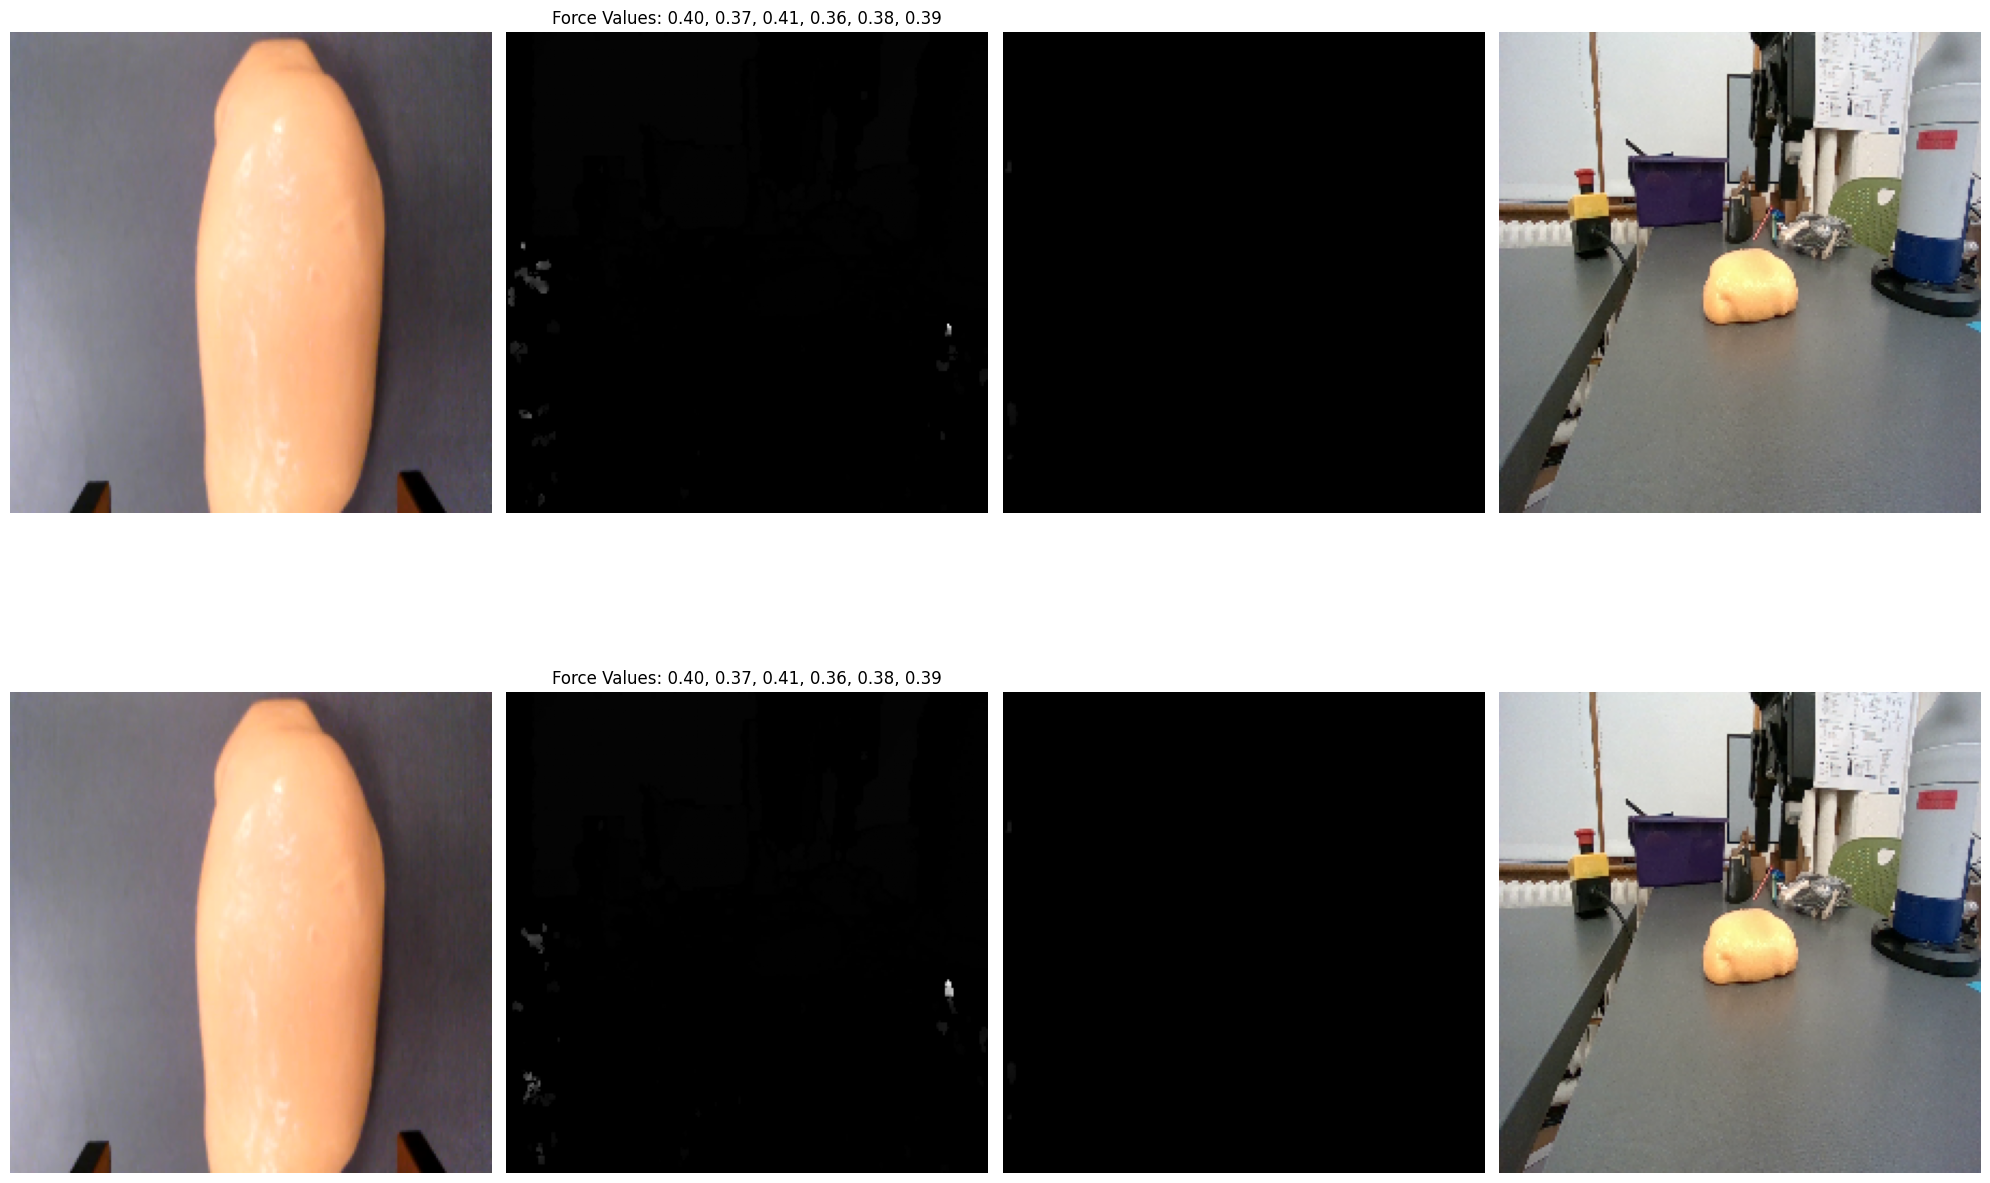

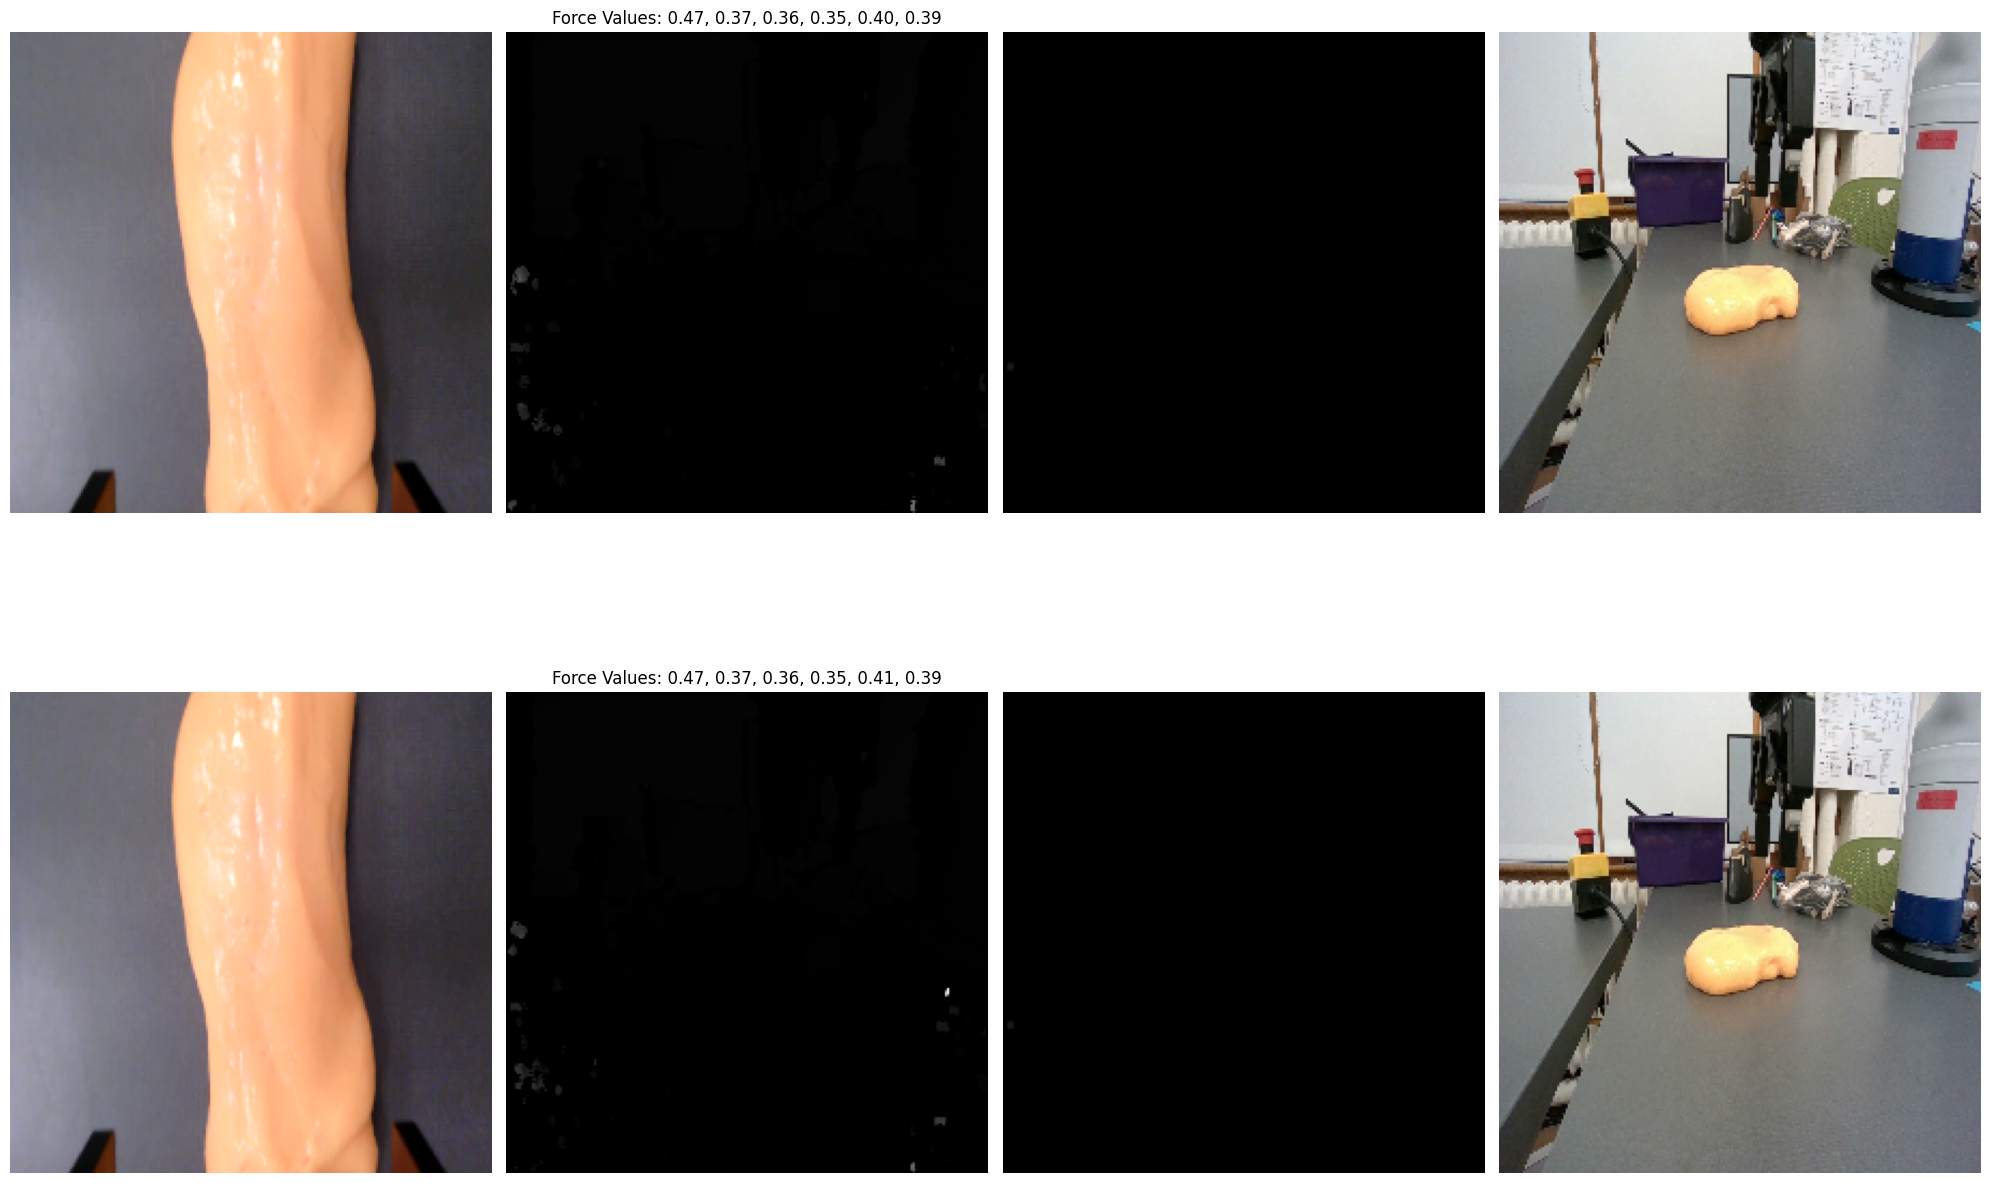

In [5]:
# def display_images_with_force(img_array, force_array, sample_index, timesteps):
#     fig, axes = plt.subplots(1, timesteps, figsize=(15, 5))
#     for i in range(timesteps):
#         ax = axes[i]
#         # Convert BGR to RGB
#         rgb_image = img_array[sample_index, i, 0][..., ::-1]
#         ax.imshow(rgb_image)
#         ax.set_title(f"Force: {force_array[sample_index, i, 0]:.2f}")  # Assuming force is one-dimensional
#         ax.axis('off')
#     plt.tight_layout()
#     plt.show()

# # Display the first four RGB images with force values from the training data
# display_images_with_force(images, force_values, 50, 4)

# # Display the first four RGB images with force values from the test data
# display_images_with_force(test_images, test_values, 50, 4)

def display_images_with_force(img_array, force_array, sample_index, timesteps):
    fig, axes = plt.subplots(timesteps, 4, figsize=(20, 15))

    for i in range(timesteps):
        force_values_str = ', '.join([f"{val:.2f}" for val in force_array[sample_index, i]])

        for j in range(4):  # Loop for 4 images per timestep
            ax = axes[i, j]
            # Convert BGR to RGB
            rgb_image = img_array[sample_index, i, j][..., ::-1]
            ax.imshow(rgb_image)

            if j == 1:  # Display the force values in the title of the second image for clarity
                ax.set_title(f"Force Values: {force_values_str}")

            ax.axis('off')

    plt.tight_layout()
    plt.show()

# these lines are displaying 2 timesteps from first sequence
# you can play around
# Display images with force values from the training data
display_images_with_force(images, force_values, 1, 2)

# Display images with force values from the test data
display_images_with_force(test_images, test_values, 1, 2)




## Creating the Model

In [6]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import TimeDistributed, Conv2D, MaxPooling2D, Flatten, LSTM, Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Reshape, Flatten

### First Try
Got this:

WARNING:tensorflow:Layer lstm_4 will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.
WARNING:tensorflow:Layer lstm_5 will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.
Epoch 1/10
6/6 [==============================] - 9s 1s/step - loss: 0.0392 - val_loss: 0.0080

Epoch 2/10
6/6 [==============================] - 1s 218ms/step - loss: 0.0056 - val_loss: 0.0055

Epoch 3/10

6/6 [==============================] - 1s 213ms/step - loss: 0.0051 - val_loss: 0.0045
Epoch 4/10

6/6 [==============================] - 1s 216ms/step - loss: 0.0046 - val_loss: 0.0045
Epoch 5/10

6/6 [==============================] - 1s 214ms/step - loss: 0.0044 - val_loss: 0.0043
Epoch 6/10

6/6 [==============================] - 1s 212ms/step - loss: 0.0044 - val_loss: 0.0043
Epoch 7/10

6/6 [==============================] - 1s 220ms/step - loss: 0.0043 - val_loss: 0.0043
Epoch 8/10

6/6 [==============================] - 1s 212ms/step - loss: 0.0043 - val_loss: 0.0043
Epoch 9/10
6/6 [==============================] - 1s 212ms/step - loss: 0.0043 - val_loss: 0.0043
Epoch 10/10
6/6 [==============================] - 1s 212ms/step - loss: 0.0043 - val_loss: 0.0043
6/6 [==============================] - 1s 78ms/step - loss: 0.0035
Test Loss on flarp_folding_2: 0.003494186792522669

In [11]:
# Keep trying:
# a simpler model
# a complex model
# train on more data
def create_cnn(input_shape):
    model = Sequential()
    # This layer applies 16 filters of size 3x3 to the input image. Each filter is meant to detect specific features in the image, such as edges, corners, textures, etc. The relu activation function introduces non-linearity to the model, allowing it to capture more complex patterns.
    model.add(Conv2D(16, (3, 3), activation='relu', input_shape=input_shape))
    # Max pooling reduces the spatial dimensions of the output from the previous layer by half. In this case, it's a 2x2 max pooling, so it picks the maximum value in every 2x2 block of the input. This helps in reducing computational requirements and makes the model more translation invariant (i.e., able to recognize features irrespective of their position in the image).
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    #  The flatten layer converts the 2D feature maps into a 1D vector. This is necessary for connecting the convolutional layers to the dense layer that follows.
    model.add(Flatten())
    # A dense (or fully connected) layer with 128 neurons. This layer can capture global patterns in the image by considering all the features extracted by the previous layers.
    model.add(Dense(128, activation='relu'))
    return model

def create_model(input_shape, num_force_features):
    # Input shape: (timesteps, number of cameras, height, width, channels)
    image_input = Input(shape=input_shape)

    # Reshape input to combine batch size, timesteps, and number of cameras
    reshaped_input = Reshape((-1, input_shape[2], input_shape[3], input_shape[4]))(image_input)

    # Process all images with CNN
    cnn_out = TimeDistributed(create_cnn((input_shape[2], input_shape[3], input_shape[4])))(reshaped_input)

    # Reshape the output to split timesteps and number of cameras
    reshaped_cnn_out = Reshape((input_shape[0], -1))(cnn_out)

    # LSTM to handle sequences of timestep data
    lstm_out = LSTM(50, return_sequences=True, recurrent_activation='sigmoid', unroll=True)(reshaped_cnn_out)
    lstm_out = LSTM(50, recurrent_activation='sigmoid', unroll=True)(lstm_out)

    output = Dense(num_force_features)(lstm_out)

    model = Model(inputs=image_input, outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

    return model



# TRYING OUT A COMPLEX MODEL WHICH DOES NOT WORK
# from tensorflow.keras.layers import Dropout, BatchNormalization, Bidirectional

# def create_cnn(input_shape):
#     model = Sequential()
#     model.add(Conv2D(16, (3, 3), activation='relu', input_shape=input_shape))
#     model.add(BatchNormalization())
#     model.add(MaxPooling2D((2, 2)))
#     model.add(Dropout(0.25))

#     model.add(Conv2D(32, (3, 3), activation='relu'))
#     model.add(BatchNormalization())
#     model.add(MaxPooling2D((2, 2)))
#     model.add(Dropout(0.25))

#     model.add(Flatten())
#     model.add(Dense(128, activation='relu'))
#     model.add(BatchNormalization())
#     model.add(Dropout(0.5))

#     return model

# def create_model(input_shape, num_force_features):
#     image_input = Input(shape=input_shape)

#     cnn = create_cnn(input_shape[2:])
#     encoded_frames = TimeDistributed(TimeDistributed(cnn))(image_input)

#     encoded_frames = Flatten()(encoded_frames)
#     encoded_frames = Reshape((input_shape[0], -1))(encoded_frames)

#     lstm_out = Bidirectional(LSTM(100, return_sequences=True, recurrent_activation='tanh', unroll=True))(encoded_frames)
#     lstm_out = Dropout(0.5)(lstm_out)
#     lstm_out = Bidirectional(LSTM(100, recurrent_activation='tanh', unroll=True))(lstm_out)
#     lstm_out = Dropout(0.5)(lstm_out)

#     output = Dense(num_force_features)(lstm_out)

#     model = Model(inputs=image_input, outputs=output)
#     model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

#     return model


In [17]:
# Get the shapes of the images and force values arrays from flarp_folding_1
num_timesteps, num_images, height, width, channels = images.shape[1:]
num_force_features = force_values.shape[-1]

# Create the model
model = create_model((num_timesteps, num_images, height, width, channels), num_force_features)

# Train the model using the training data from flarp_folding_1 and validate on flarp_folding_3
# Why force_values[:, -1, :]
# This is the target data for the training. The indexing [:, -1, :] selects the force values for the last timestep of each sequence. This means that the model is being trained to predict the force values for the last timestep based on the images from all timesteps.
# If force_values has a shape (182, 4, 6), after the indexing, it will have a shape (182, 6).
history = model.fit(images, force_values[:, -1, :],
                    validation_data=(val_images, validation_values[:, -1, :]),
                    epochs=10, batch_size=8)

# Evaluate the model on the test data from flarp_folding_2
test_loss = model.evaluate(test_images, test_values[:, -1, :])
print(f'Test Loss on flarp_folding_2: {test_loss}')

Epoch 1/10
23/23 [==============================] - 13s 381ms/step - loss: 0.0182 - val_loss: 0.0046
Epoch 2/10
23/23 [==============================] - 3s 119ms/step - loss: 0.0046 - val_loss: 0.0045
Epoch 3/10
23/23 [==============================] - 3s 119ms/step - loss: 0.0049 - val_loss: 0.0046
Epoch 4/10
23/23 [==============================] - 3s 122ms/step - loss: 0.0046 - val_loss: 0.0052
Epoch 5/10
23/23 [==============================] - 3s 121ms/step - loss: 0.0048 - val_loss: 0.0050
Epoch 6/10
23/23 [==============================] - 3s 119ms/step - loss: 0.0048 - val_loss: 0.0048
Epoch 7/10
23/23 [==============================] - 3s 120ms/step - loss: 0.0047 - val_loss: 0.0044
Epoch 8/10
23/23 [==============================] - 3s 121ms/step - loss: 0.0045 - val_loss: 0.0044
Epoch 9/10
23/23 [==============================] - 3s 120ms/step - loss: 0.0045 - val_loss: 0.0048
Epoch 10/10
6/6 [==============================] - 1s 128ms/step - loss: 0.0040
Test Loss on flarp_

In [19]:
from sklearn.metrics import r2_score

# Predict force values on validation data
val_predictions = model.predict(val_images)

# Compute R^2 score for validation data
val_r2_score = r2_score(validation_values[:, -1, :], val_predictions)
print(f'Validation R^2 Score on flarp_folding_3: {val_r2_score}')

# If you want to compute R^2 score for test data (flarp_folding_2):
test_predictions = model.predict(test_images)
test_r2_score = r2_score(test_values[:, -1, :], test_predictions)
print(f'Test R^2 Score on flarp_folding_2: {test_r2_score}')


InternalError: ignored

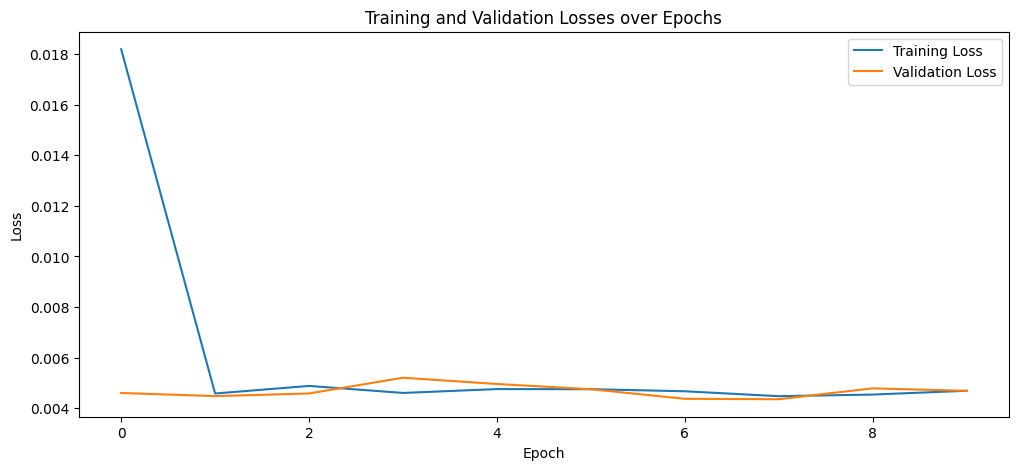

In [20]:
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Losses over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

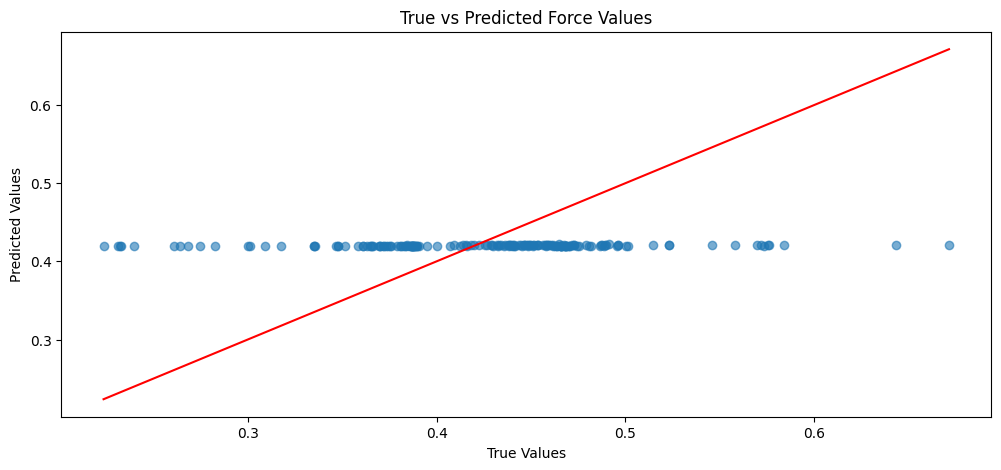

In [21]:
plt.figure(figsize=(12, 5))
plt.scatter(validation_values[:, -1, 0], val_predictions[:, 0], alpha=0.6)
plt.plot([min(validation_values[:, -1, 0]), max(validation_values[:, -1, 0])],
         [min(validation_values[:, -1, 0]), max(validation_values[:, -1, 0])],
         color='red')
plt.title('True vs Predicted Force Values')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.show()

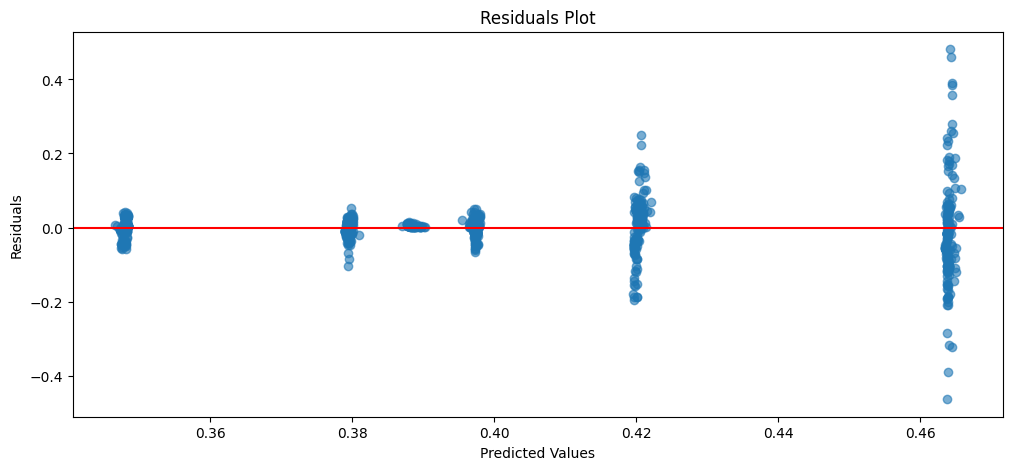

In [22]:
residuals = validation_values[:, -1, :] - val_predictions

plt.figure(figsize=(12, 5))
plt.scatter(val_predictions, residuals, alpha=0.6)
plt.axhline(y=0, color='red')
plt.title('Residuals Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()